Esse código utiliza a Análise de Bollinger e o Índice de Força Relativa (IFR) para determinar quando comprar e vender ativos.  
- A Análise de Bollinger é uma ferramenta de análise técnica que utiliza médias móveis e desvios padrão para determinar quando um ativo está sobrecomprado ou sobrevendido.  
- O Índice de Força Relativa (IFR) é um indicador de momentum que mede a velocidade e a mudança dos movimentos de preços.

In [1]:
# Importar as bibliotecas necessárias
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [2]:
# Define uma função para criar e obter as bandas de Bollinger
def bollinger_bands(data, window_size = 30):
    rolling_mean = data['Close'].rolling(window = window_size).mean()  # Calcula a média móvel
    rolling_std  = data['Close'].rolling(window = window_size).std()   # Calcula o desvio padrão
    data['Bollinger High'] = rolling_mean + (rolling_std * 2)          # Calcula a banda superior
    data['Bollinger Low']  = rolling_mean - (rolling_std * 2)          # Calcula a banda inferior
    return data

In [3]:
# Define uma função para criar e obter o IFR
def IFR(data, window = 13):
    delta = data['Close'].diff()            # Calcula a diferença entre os preços de fechamento
    gain = delta.where(delta > 0, 0)        # Calcula os ganhos
    loss = delta.where(delta < 0, 0)        # Calcula as perdas
    avg_gain = gain.rolling(window).mean()  # Calcula a média dos ganhos
    avg_loss = loss.rolling(window).mean()  # Calcula a média das perdas
    FR = avg_gain / avg_loss                # Calcula a razão de força
    IFR = 100 - (100 / (1 + FR))            # Calcula o IFR
    data['IFR'] = IFR                       # Adiciona o IFR ao dataframe
    data['Sobrecompra'] = 70                # Define o nível de sobrecompra
    data['Sobrevenda'] = 30                 # Define o nível de sobrevenda
    return data

In [4]:
# Define uma função para criar e obter a estraégia de compra e venda
# Compra quando o preço de fechamento cruza a banda inferior de Bollinger e o IFR está abaixo de 30
# Vende quando o preço de fechamento cruza a banda superior de Bollinger e o IFR está acima de 70
def estrategia(data):
    posicao = 0
    preco_compra = []
    preco_venda = []
    for i in range(len(data)):
        if data['Close'][i] < data['Bollinger Low'][i] and data['IFR'][i] < data['Sobrevenda'][i] and posicao == 0:
            posicao = 1
            preco_compra.append(data['Close'][i])
            preco_venda.append(np.nan)
        elif data['Close'][i] > data['Bollinger High'][i] and data['IFR'][i] > data['Sobrecompra'][i] and posicao == 1:
            posicao = 0
            preco_venda.append(data['Close'][i])
            preco_compra.append(np.nan)
        else:
            preco_venda.append(np.nan)
            preco_compra.append(np.nan)
    return (preco_compra, preco_venda)

In [5]:
# Definir o dia de hoje em uma variável
hoje = pd.Timestamp.today().strftime('%Y-%m-%d')

# Obter os dados do ativo
data = yf.download('BTC-USD', start='2017-01-01', end=hoje)
data.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-01-01,963.658020,1003.080017,958.698975,998.325012,998.325012,147775008
2017-01-02,998.617004,1031.390015,996.702026,1021.750000,1021.750000,222184992
2017-01-03,1021.599976,1044.079956,1021.599976,1043.839966,1043.839966,185168000
2017-01-04,1044.400024,1159.420044,1044.400024,1154.729980,1154.729980,344945984
2017-01-05,1156.729980,1191.099976,910.416992,1013.380005,1013.380005,510199008


In [6]:
data.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-06-30,30441.353516,31256.863281,29600.275391,30477.251953,30477.251953,26387306197
2023-07-01,30471.847656,30641.289062,30328.865234,30590.078125,30590.078125,9086606733
2023-07-02,30587.269531,30766.140625,30264.019531,30620.769531,30620.769531,10533418042
2023-07-03,30624.515625,31375.613281,30586.513672,31156.439453,31156.439453,15271884873
2023-07-04,31156.865234,31325.197266,30659.355469,30777.582031,30777.582031,12810828427


In [7]:
data.shape

(2376, 6)

In [8]:
# Adicionar as bandas de Bollinger ao dataframe
data = bollinger_bands(data)

In [9]:
# Adicionar o IFR ao dataframe
data = IFR(data)

In [10]:
# Implementar a estratégia de compra e venda
preco_compra, preco_venda = estrategia(data)
data['Preço de Compra'] = preco_compra
data['Preço de Venda'] = preco_venda

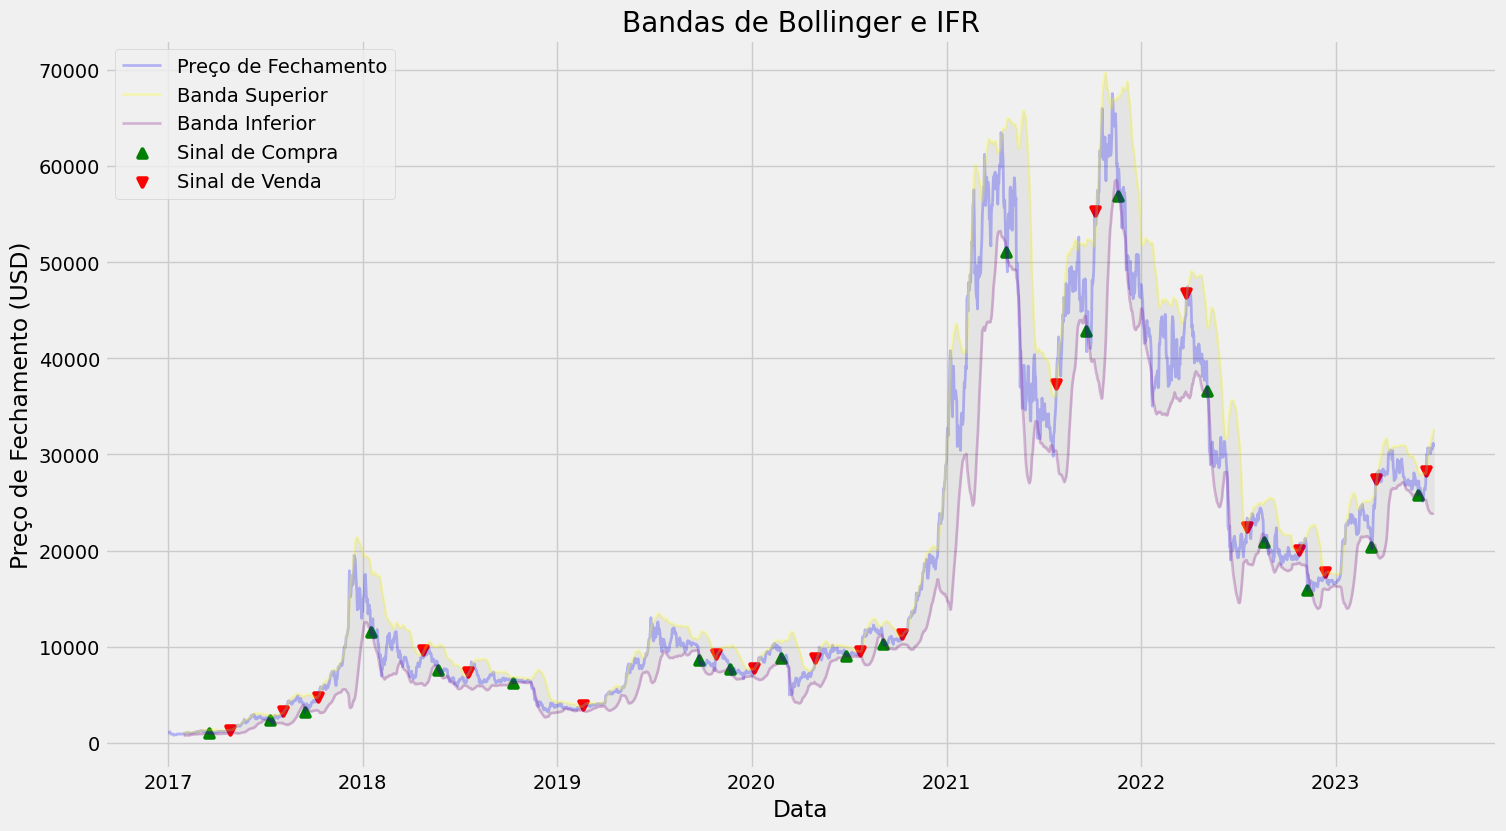

In [13]:
# Plotar o preço de fechamento, as bandas de Bollinger e os sinais de compra e venda
fig, ax = plt.subplots(figsize=(16,9))
plt.title('Bandas de Bollinger e IFR')
plt.ylabel('Preço de Fechamento (USD)')
plt.xlabel('Data')
ax.plot(data['Close'], color = 'blue', lw = 2, label = 'Preço de Fechamento', alpha = 0.25)
ax.plot(data['Bollinger High'], color = 'yellow', lw = 2, label = 'Banda Superior', alpha = 0.25)
ax.plot(data['Bollinger Low'], color = 'purple', lw = 2, label = 'Banda Inferior', alpha = 0.25)
ax.fill_between(data.index, data['Bollinger High'], data['Bollinger Low'], color = 'gray', alpha = 0.1)
ax.scatter(data.index, data['Preço de Compra'], color = 'green', lw = 3, label = 'Sinal de Compra', marker = '^', alpha = 1)
ax.scatter(data.index, data['Preço de Venda'], color = 'red', lw = 3, label = 'Sinal de Venda', marker = 'v', alpha = 1)
plt.legend(loc = 'upper left')
plt.show()